# Introduction


**What?** How to Develop a CNN for Image Classification



# Theoretical recall: ML life cycle and what a CNN is


The five steps in the life-cycle are as follows:

1. Prepare the Data.
- Define the Model.
- Train the Model.
- Evaluate the Model.
- Make Predictions.

Convolutional Neural Networks, or CNNs for short, are a type of network designed for image input.



# Import modules

In [14]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from matplotlib import pyplot
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# Load the datatest


- A  popular image classification task is the MNIST handwritten digit classification. It involves tens of thousands of handwritten digits that must be classified as a number between 0 and 9.

- PyTorch provides the **Dataset** class that you can extend and customize to load your dataset
- **__len__()** function that can be used to get the length of the dataset
- **__getitem__()** function that is used to get a specific sample by index.
- PyTorch provides the **DataLoader** class to navigate a Dataset instance during the training and evaluation of your model. We use it to create the training & test dataset, and even a validation dataset.
-



In [8]:
# define location to save or load the dataset
path = './MNIST'
# define the transforms to apply to the data
trans = Compose([ToTensor()])
# download and define the datasets
train = MNIST(path, train=True, download=True, transform=trans)
test = MNIST(path, train=False, download=True, transform=trans)
# define how to enumerate the datasets
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)

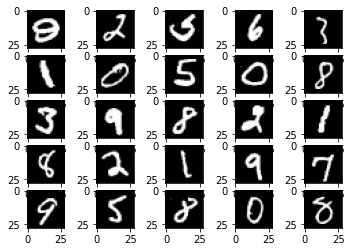

In [9]:
# get one batch of images
i, (inputs, targets) = next(enumerate(train_dl))
# plot some images
for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(inputs[i][0], cmap='gray')
# show the figure
pyplot.show()


- It is a good idea to scale the pixel values from the default range of 0-255 to have a zero mean and a standard deviation of 1



In [15]:
# prepare the dataset
def prepare_data(path):
    # define standardization
    trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # load dataset
    train = MNIST(path, train=True, download=True, transform=trans)
    test = MNIST(path, train=False, download=True, transform=trans)
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [16]:
# prepare the data
path = './MNIST'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

60000 10000


# Building the MLP model


- It is a good practice to use a non linear activation with a weight initialisation.
- This combination help combact the problem of vanishing gradients.
- The **pyTorch idiom** to define a model is todefine the layers in the class constructor and then use the **forward()** function to define how to propagate the inputs truough the the layers.
-



In [17]:
class CNN(Module):
    # define model elements
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        # fully connected layer
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # flatten
        X = X.view(-1, 4*4*50)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X

In [18]:
# Where is the number of input
model = CNN(1)

# Train the model


- **SGD:** Stochastic gradient descent is used for optimization
- First, a loop is required for the number of training epochs. Then an inner loop is required for the mini-batches for stochastic gradient descent.

Each update to the model involves the **same** general pattern comprised of:

1. Clearing the last error gradient.
- A forward pass of the input through the model.
- Calculating the loss for the model output.
- Backpropagating the error through the model.
- Update the model in an effort to reduce loss.



In [19]:
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [20]:
# train the model
train_model(train_dl, model)

# Evaluate the model


- Once the model is fit, it can be evaluated on the test dataset.
- This can be achieved by using the DataLoader for the test dataset and collecting the predictions for the test set, then comparing the predictions to the expected values of the test set and calculating a performance metric.
- If run on CPUs this will take a while.



In [21]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [22]:
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.987


# References


- https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/<br>

